# Exercises

We have prepared five exercises in this chapter:

1. Modify the HCM code to work for three groups. This exercise can be divded into four tasks: 
    - modify the parameters,
    - modify the calculate_u function,
    - execute the clustering,
    - plot the results.
2. For density clustering, plot the feature space with all element marked with different color, depending on the cluster that it's assigned to. You should do the following tasks:
    - fill the get_color method,
    - fill the plot code.
3. Build a method that plot baed on dendrograms_history and pydot, a dendrogram for the divisive clustering method. You should base on agglomerative method, but keep in mind that it works top-down instead of bottom-up. This exercise need just one function to be implemented:
    - show_tree_divisive. 
    You should loop over the dendrogram_history variable and loop over childs.
4. Implement the $s_{2}$ metric   
5. Draw the borders between clusters in the output image (for 5.0 grade)

## Libraries

To solve the exercises, we need the following libraries to load in the first place.


In [55]:
import numpy
import random
import numpy as np
import pandas as pd
from math import sqrt

import matplotlib.image as img
from PIL import Image

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image

## Exercise 1: Modify the HCM code to work for three groups

The obvious part is the variable ```groups```, but the most changes needs to be done here:

In [56]:
X=np.array([(4,1940),(9,2960),(9,4630),(78,1528),(90,2040),(50,3700),(467,14815),(509,15200),(290,15700),(215,6045)])
train_data = np.array(X)
max_values = train_data.max(0)

X_norm = np.divide(train_data,max_values)
data_set = X_norm

In [57]:
### change here:
groups = 3

error_margin = 0.01
m=2
assignation=np.zeros((len(data_set),groups))

centers = np.array([[0.01229673, 0.25183492],
       [0.3689626 , 0.61904127],
       [0.95732769, 0.45059586]])

centers = np.array([[0.01229673, 0.25183492],
       [0.3689626 , 0.61904127],
       [0.95732769, 0.45059586]])

def calculate_distance(x,v):
    return sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

def calculate_new_centers(u):
    new_centers=[]
    for c in range(groups):
        u_x_vector=np.zeros(2)
        u_scalar=0.0
        for i in range(len(data_set)):
            u_scalar = u_scalar+(u[i][c]**m)
            u_x_vector=np.add(u_x_vector,np.multiply(u[i][c]**m,data_set[i]))
        new_centers.append(np.divide(u_x_vector,u_scalar))
    return new_centers

def calculate_differences(new_assignation, assignation):     
    return np.sum(np.abs(np.subtract(assignation,new_assignation)))

def cluster_hcm(assignation,centers):
    difference_limit_not_achieved=True
    new_centers = centers
    iter=0
    while difference_limit_not_achieved:
        new_assignation=[]
        for i in range(len(data_set)):
            new_assignation.append(calculate_u_three(data_set[i]))
        new_centers = calculate_new_centers(new_assignation)
        if iter>0:
            if calculate_differences(new_assignation, assignation) < error_margin:
                difference_limit_not_achieved=False
        assignation=new_assignation
        iter=iter+1
    return new_assignation, new_centers

### Modify the ``calculate_u`` function

Fill the gap below to make the function working for more groups than two. The goal here is to calculate the distance between ``x`` and the center of a given group and append the value to ``minimal_distance``.

In [58]:
def calculate_u_three(x):
    u_array = np.zeros(groups)
    minimal_distance = []
    for group in range(groups):
        minimal_distance.append(calculate_distance(x, centers[group]))       
    min_group_id = np.argmin(minimal_distance)
    u_array[min_group_id] = 1
    return u_array

### Execute the clustering

As in the previous example we need to cluster it.

In [59]:
new_assignation_hcm3, new_centers_hcm3 = cluster_hcm(assignation, centers)
pd.DataFrame(new_centers_hcm3)

,0,1
0,0.078585,0.178323
1,0.496071,0.692516
2,0.958743,0.955892


### Plot the results

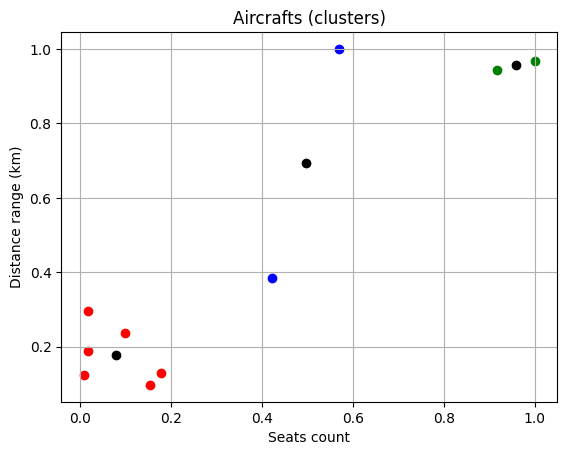

In [60]:
red = data_set[np.where(np.array(new_assignation_hcm3)[:,0]==1)]
blue = data_set[np.where(np.array(new_assignation_hcm3)[:,1]==1)]
green = data_set[np.where(np.array(new_assignation_hcm3)[:,2]==1)]

fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(green[:,0],green[:,1],c='green')
ax.scatter(np.array(new_centers_hcm3)[:,0],np.array(new_centers_hcm3)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

## Exercise 2: Plot the density clusters

Use the code below to plot the results. You can play with the max_distance variable to get more or less groups.

In [63]:
max_distance = 0.25
min_points = 2
assignation = np.zeros(len(data_set))

def calculate_distance(x,v):
    return sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

def calculate_distance_matrix():
    distance_matrix = np.zeros((len(data_set),len(data_set)))
    for i in range(len(data_set)):
        for j in range(len(data_set)):
            distance_matrix[i, j] = calculate_distance(data_set[i], data_set[j])
    return distance_matrix

def get_closest_elements(distance_matrix, element_id):
    element_distances = distance_matrix[element_id]
    filtered = {}
    iter = 0
    for element in element_distances:
        if element < max_distance:
            filtered[iter] = element
        iter = iter + 1
    return filtered

def set_as_noise(assignation,element_id):
    assignation[element_id] = -1
    return assignation

def set_visited(elements, assignation, number_of_clusters):
    for element_id in elements.keys():
        assignation[element_id] = number_of_clusters
    return assignation

def cluster_density(assignation):
    number_of_cluster = 0
    distance_matrix = calculate_distance_matrix()
    element_ids = list(range(len(data_set)))
    random.shuffle(element_ids)
    for i in element_ids:
        if assignation[i] != 0:
            continue
        closest = get_closest_elements(distance_matrix, i)
        if len(closest) < min_points:
            assignation = set_as_noise(assignation,i)
        else:
            assignation = set_visited(closest, assignation, number_of_cluster)
            number_of_cluster = number_of_cluster + 1
    return assignation

new_assignation_density = cluster_density(assignation)

### Fill the ``get_group_objects`` method

Only one line needs to be updated. The ``get_group_objects`` function should return the objects of a given group.

In [64]:
colors = ['red','blue','green','orange','black','yellow']
    
def get_group_objects(color_id):
    return data_set[np.where(new_assignation_density == color_id)]

### Fill the plot code

If done properly the code below should return a plot of two clusters and the noise.

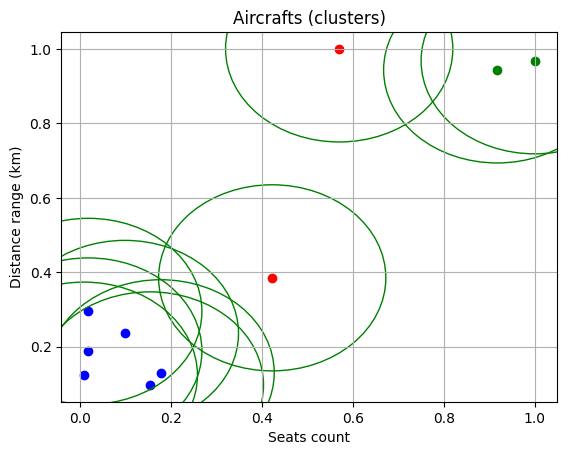

In [65]:
colors = ['red','blue','green','orange','black','yellow']

fig, ax = plt.subplots()

assigned_groups = new_assignation_density
for group in np.unique(assigned_groups):
    small_set = get_group_objects(group) 
    ax.scatter(small_set[:,0],small_set[:,1],c=colors.pop(0))
    for circle in small_set:
        circle1 = plt.Circle((circle[0],circle[1]), 0.25, color='green', fill=False)        
        ax.add_artist(circle1)
    
ax.set(xlabel='Seats count', ylabel='Distance range (km)',title='Aircrafts (clusters)')
ax.grid()
plt.show()

## Exercise 3: Build a dendrogram using dendrograms_history and pydot (done)

In this exercise we gonna use the variable dendrograms_history and pydot. Below we restore the variable and initialize the dendrogram graph.

In [ ]:
%store -r dendrogram_hist_diana

### Fill ``show_tree_divisive`` function

The function show_tree_divisive goes through each child node and build and edge between.

In [ ]:
def show_tree_divisive():
    for item in dendrogram_hist_diana:
        for child in item[0]["childs"]:
            # fill the gap (2 lines)
            #
    tree.write('tree_diana.png',format='png')
    
show_tree_divisive()

Take a look if you did it properly:

In [ ]:
from IPython.display import Image
Image(filename='tree_diana.png') 

## Exercise 4: Implement the $s_{2}$ metric

The $s_{2}$ metric gives a better understanding of the distances between centers.

\begin{equation}
 s_{2}(c_{i},c_{j})=d(c_{i},c_{j}).
\end{equation}

Let's restore the centers from HCM grouped by two and initialize the values for three groups as below.

In [ ]:
%store -r new_centers_hcm

new_centers_hcm = np.array(new_centers_hcm)
new_centers_hcm3 = np.array([[0.42239686, 0.38503185],[0.07858546, 0.17832272],[0.82907662, 0.97059448]])

Measure the distance between each center.

In [ ]:
def calculate_s_2(centers):
    s2 = []
    for center_1 in range(len(centers)):
        for center_2 in range(len(centers)):
            # fill the code here (3 lines)
    return s2

## Exercise 5: Modify the output image with borders between clusters

We use the ``Segmentation`` class as in previous example.

In [ ]:
class Segmentation:

    def __init__(self, feature_matrix, groups):
        self.__data_set = feature_matrix
        self.__groups = groups
        self.__space=[[0, 255], [0, 255], [0, 255]]
        self.__error_margin = 0.5
        self.assignation = np.zeros((len(self.__data_set), self.__groups))
        self.centers = []
        self.select_centers()

    def select_centers(self):
        if len(self.centers) == 0:
            iter=0
            while iter<self.__groups:
                self.centers.append(((random.randrange(0, 255)*1.0/255),
                                     (random.randrange(0, 255)*1.0/255),
                                     (random.randrange(0, 255)*1.0/255)))
                iter=iter+1

    def calculate_distance(self, x, v):
        return sqrt((x[0]-v[0])**2+(x[1]-v[1])**2+(x[2]-v[2])**2)

    def calculate_u(self, x, i):
        smallest_distance = float(self.calculate_distance(x, self.centers[0]))
        smallest_id = 0
        for i in range(1, self.__groups):
            distance = self.calculate_distance(x, self.centers[i])
            if distance < smallest_distance:
                smallest_id = i
                smallest_distance = distance
        distance = np.zeros(self.__groups)
        distance[smallest_id]=1
        return distance

    def calculate_new_centers(self, u):
        new_centers=[]
        for c in range(self.__groups):
            u_x_vector = np.zeros(len(self.centers[0]))
            u_scalar = 0
            for i in range(len(u)):
                u_scalar = u_scalar + u[i][c]
                u_x_vector = np.add(u_x_vector, np.multiply(u[i][c], self.__data_set[i]))
            new_centers.append(np.divide(u_x_vector,u_scalar))
        self.centers = new_centers

    def calculate_differences(self,new_assignation):
        diff=0
        for i in range(len(self.assignation)):
            for j in range(self.__groups):
                diff = diff + abs(float(new_assignation[i][j]) - float(self.assignation[i][j]))
        return diff

    def do_segmentation(self):
        difference_limit_not_achieved = True
        iter = 0
        while difference_limit_not_achieved:
            new_assignation = []
            for i in range(len(self.__data_set)):
                new_assignation.append(self.calculate_u(self.__data_set[i], iter))
            self.calculate_new_centers(new_assignation)

            if iter > 0:
                if self.calculate_differences(new_assignation) < self.__error_margin:
                    difference_limit_not_achieved=False
            self.assignation = new_assignation
            iter = iter + 1

    def get_results(self):
        return self.centers, self.assignation

### Change ``save_image`` method 

Add an if statement in the code below. It should consider the change of ``current_pixel`` variable. Please keep in mind that there should be three states considered.

In [ ]:
class ImageConversion:

    def get_image_from_url(self, img_url):
        image = open(img_url,'rb')
        return img.imread(image)

    def get_unique_colours(self, image_matrix):
        feature_matrix = []
        for i in range(len(image_matrix)):
            for j in range(len(image_matrix[0])):
                feature_matrix.append(image_matrix[i, j])
        feature_matrix_np = np.array(feature_matrix)
        uniques, index = np.unique([str(i) for i in feature_matrix_np], return_index=True)
        return feature_matrix_np[index], feature_matrix

    def save_image(self, size, pixel_matrix, unique_matrix, assignation_matrix, colours, output):
        image_out = Image.new("RGB", size)
        pixels = []
        current_pixel = None ## added
        for i in range(len(pixel_matrix)):
            pixel_list = pixel_matrix[i].tolist()
            for j in range(len(unique_matrix)):
                if (pixel_list == unique_matrix[j].tolist()):
                    for k in range(len(colours)):
                        if assignation_matrix[j][k] == 1:
                            segmented_colours = [int(i) for i in (colours[k] * 255)]
                            # fill here (about 6-7 lines)
        image_out.putdata(pixels)
        image_out.save(output)
        
    def do_segmentation(self):
        difference_limit_not_achieved = True
        iter = 0
        while difference_limit_not_achieved:
            new_assignation = []
            for i in range(len(self.__data_set)):
                new_assignation.append(self.calculate_u(self.__data_set[i], iter))
            self.calculate_new_centers(new_assignation)
            if iter > 0:
                if self.calculate_differences(new_assignation) < self.__error_margin:
                    difference_limit_not_achieved=False
            self.assignation = new_assignation
            iter = iter + 1

    def get_results(self):
        return self.centers, self.assignation        

Execute segmentation without any changes:

In [ ]:
image_to_segment = "images/logo_krakow.png"
image_converter = ImageConversion()
image_data = image_converter.get_image_from_url(image_to_segment)
unique_image_data, image_data_list = image_converter.get_unique_colours(image_data)

groups = 3

segmentation = Segmentation(unique_image_data, groups)
segmentation.do_segmentation()
centers, assignation_matrix = segmentation.get_results()

image_size = (232, 258)
image_converter.save_image(image_size, image_data_list, unique_image_data, assignation_matrix, centers, "images/segmented.png")

The image should have black broders between one and the other segment.

In [ ]:
from IPython.display import Image
Image("images/segmented.png")